In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

%cd '/content/gdrive/My Drive/automated-essay-grading-master'

/content/gdrive/My Drive/automated-essay-grading-master


In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

Using TensorFlow backend.


In [0]:
import re
import os as os
import numpy as np
import itertools
import pandas as pd
from collections import Counter

def load_training_data(training_path, essay_set=1):
    training_df = pd.read_csv(training_path, delimiter='\t', encoding = "ISO-8859-1")
    # resolved score for essay set 1
    resolved_score = training_df[training_df['essay_set'] == essay_set]['domain1_score']
    essay_ids = training_df[training_df['essay_set'] == essay_set]['essay_id']
    essays = training_df[training_df['essay_set'] == essay_set]['essay']
    essay_list = []
    # turn an essay to a list of words
    for idx, essay in essays.iteritems():
        essay = clean_str(essay)
        #essay_list.append([w for w in tokenize(essay) if is_ascii(w)])
        essay_list.append(essay)
    return essay_list, resolved_score.tolist(), essay_ids.tolist()


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    return string.strip().lower()


In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
max_senten_len=811
max_senten_num=1
embed_size=100
VALIDATION_SPLIT = 0.1

In [0]:
training_path='Copy of training_set_rel3_V2.tsv'
essay_list = []
resolved_scores=[]
for i in range(5,6):
  essays, resolved, essay_id = load_training_data(training_path,essay_set=i+1)
  for  essay in essays:
        essay_list.append(essay)
  for  essay in resolved:
        resolved_scores.append(essay)
  
  #essay_list.append(essay)
  #resolved_scores.append(resolved)
  print("essay_set :",i+1)
  print("max :",max(resolved_scores))
  print("min:",min(resolved_scores))
  print("lenth :",len(essay_list))

essay_set : 6
max : 4
min: 0
lenth : 1800


In [0]:


a = map(lambda x :math.floor((x/12)*5),demo_score) 



In [0]:

#print(min(resolved_scores))
demo_score=list(a)
print(max(demo_score))

1


In [0]:
paras = []
labels = []
texts = []
import nltk
nltk.download('punkt')
from nltk import tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
sent_lens = []
sent_nums = []
for idx in range(len(essay_list)):
    text = clean_str(essay_list[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

In [0]:
print(essay_list[0])
print(paras[0])

there were many obstacles that the builders faced in attempting to have dirigibles dock at the empire state building safety was an issue with the dirigibles because of the highly flammable gas hydrogen so , if the dirigibles explode over new york many people could be killed in the very populated another problem is keeping the derigible caps1 so people can get off while the wind moves the back end of itself the only way was to tie lead weights down in the back of the dirigible , but it would be dangerous over people down below so , these obstacles workers faced , never got past them and so they made the world 's highest soda fountain and tea garden for tourists in the observation area
["there were many obstacles that the builders faced in attempting to have dirigibles dock at the empire state building safety was an issue with the dirigibles because of the highly flammable gas hydrogen so , if the dirigibles explode over new york many people could be killed in the very populated another 

In [0]:
tokenizer = Tokenizer( oov_token=True)
tokenizer.fit_on_texts(essay_list)

In [0]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<10000000000:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [0]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 5338 unique tokens.


In [0]:
labels = pd.get_dummies(resolved_scores)
#labels = pd.get_dummies(demo_score)
print(labels)

      0  1  2  3  4
0     0  0  1  0  0
1     0  0  0  1  0
2     0  0  0  0  1
3     0  1  0  0  0
4     0  0  0  1  0
...  .. .. .. .. ..
1795  1  0  0  0  0
1796  0  0  1  0  0
1797  0  0  0  1  0
1798  0  0  1  0  0
1799  0  0  1  0  0

[1800 rows x 5 columns]


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
[0, 1, 2, 3, 4]
[42, 151, 361, 740, 326]
[2, 16, 44, 77, 41]


In [0]:
X = data
Y = labels

In [0]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [0]:
!unzip 'glove/glove.6B.100d.txt.zip'

Archive:  glove/glove.6B.100d.txt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [0]:
GLOVE_DIR = "glove/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 1161 which is 21.75 % of total words


In [0]:
print(len(embedding_matrix))

5339


experimnet for visulize data


In [0]:
'''MODEL for experiment'''
from keras import optimizers

r_optimizer = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
embed_size=100
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(100, return_sequences=True,activation='sigmoid', kernel_regularizer=l2_reg),merge_mode='concat')(word_sequences)
word_dense = TimeDistributed(Dense(150, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)
wordEncoder.summary()
sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
#sent_lstm = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2_reg),merge_mode='concat')(sent_encoder)
#sent_dense = TimeDistributed(Dense(150 ,activation='sigmoid',kernel_regularizer=l2_reg))(sent_lstm)
sent_att =  Dropout(0.5)(AttentionWithContext()(sent_encoder))
preds = Dense(5, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer=r_optimizer,metrics=['acc'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 811)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 811, 100)          533900    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 811, 200)          160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 811, 150)          30150     
_________________________________________________________________
attention_with_context_3 (At (None, 150)               22800     
Total params: 747,650
Trainable params: 213,750
Non-trainable params: 533,900
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
Layer (type)                 O

In [0]:
'''MODEL'''
embed_size=100


embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg),merge_mode='concat')(word_sequences)
word_dense = TimeDistributed(Dense(200,activation='sigmoid',kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg),merge_mode='concat')(sent_encoder)
sent_dense = TimeDistributed(Dense(200,activation='sigmoid' ,kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(5, activation='softmax')(sent_att)
model = Model(sent_input, preds)

#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [0]:
# here we used concat in bilstm and trained for 15 epoches with batch size 32 

In [0]:
checkpoint = ModelCheckpoint('best_model(experimental)_kathiya.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32, callbacks=[checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1620 samples, validate on 180 samples
Epoch 1/200
1620/1620 [==============================] - 54s 33ms/step - loss: 1.4263 - acc: 0.4105 - val_loss: 1.3078 - val_acc: 0.4278
Epoch 2/200
1620/1620 [==============================] - 52s 32ms/step - loss: 1.3268 - acc: 0.4395 - val_loss: 1.2732 - val_acc: 0.4278
Epoch 3/200
1620/1620 [==============================] - 53s 33ms/step - loss: 1.2291 - acc: 0.4722 - val_loss: 1.1562 - val_acc: 0.5056
Epoch 4/200
1620/1620 [==============================] - 54s 33ms/step - loss: 1.1299 - acc: 0.5037 - val_loss: 1.0877 - val_acc: 0.4667
Epoch 5/200
1620/1620 [==============================] - 52s 32ms/step - loss: 1.0963 - acc: 0.5086 - val_loss: 1.0982 - val_acc: 0.4944
Epoch 6/200
1620/1620 [==============================] - 51s 32ms/step - loss: 1.0546 - acc: 0.5235 - val_loss: 0.9909 - val_acc: 0.5611
Epoch 7/200
1620/1620 [============

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


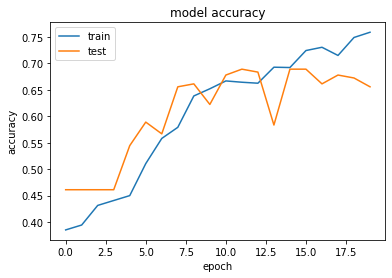

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

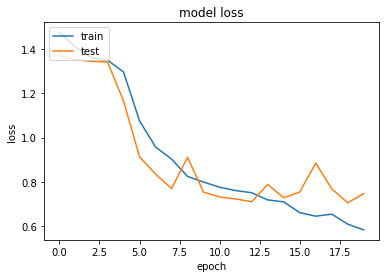

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.evaluate(x_val, y_val)

180/180 [==============================] - 1s 6ms/step


[0.7465940839714474, 0.6555555568801033]

In [0]:
model.save('BEST_Model_with_acc_.h5')

In [0]:
model_yaml = model.to_yaml()
with open("BEST_Model_with_acc_79_yaml.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("BEST_Model_with_acc_79_weights.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
testPredict = model.predict(x_val)

In [0]:
score = model.evaluate(x_val, y_val, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

180/180 [==============================] - 1s 6ms/step
Test Score: 0.7465940839714474
Test Accuracy: 0.6555555568801033


In [0]:
result = []
for i in testPredict:
  m = max(i) 
 
  idx = i.tolist().index(m)
  
  result.append(idx)

In [0]:
s2 = y_val.idxmax(axis=1)

In [0]:
print(s2)
print(result)

1687    0
1378    4
1340    2
1720    3
463     2
       ..
1791    2
950     3
408     4
438     3
856     3
Length: 180, dtype: int64
[1, 3, 3, 3, 2, 2, 4, 3, 3, 3, 3, 2, 2, 2, 4, 3, 3, 3, 2, 1, 1, 3, 2, 4, 2, 4, 4, 1, 3, 1, 3, 4, 4, 3, 4, 3, 3, 3, 4, 2, 3, 3, 3, 2, 1, 2, 4, 3, 3, 3, 4, 4, 4, 3, 2, 3, 4, 2, 2, 3, 3, 1, 4, 3, 2, 3, 1, 3, 3, 4, 2, 3, 4, 3, 3, 4, 2, 1, 2, 3, 3, 3, 2, 1, 3, 1, 3, 2, 3, 3, 3, 2, 1, 2, 3, 4, 3, 3, 4, 1, 3, 1, 1, 1, 2, 3, 2, 4, 2, 2, 2, 3, 2, 3, 4, 4, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 4, 3, 3, 2, 4, 1, 3, 3, 2, 3, 3, 2, 3, 3, 4, 1, 4, 2, 1, 2, 2, 3, 4, 3, 4, 2, 4, 2, 4, 2, 3, 4, 3, 3]


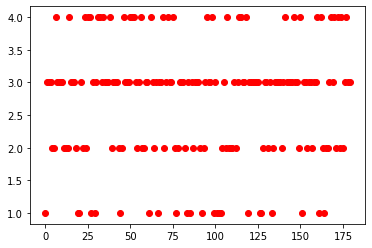

In [0]:
plt.scatter(range(len(result)),result,c='r')


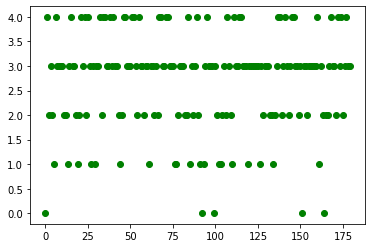

In [0]:
plt.scatter(range(len(s2)),s2,c='g')

In [0]:
from keras.models import load_model
#from AttentionWithContext import create_custom_objects

history = load_model('experimental_han.h5', custom_objects=create_custom_objects())

model.evaluate(x_val, y_val) # or model.predict

In [0]:
history.evaluate(x_val, y_val) # or model.predict

# Evolution by entering own Esssay and get marks **according** **bold text**